# Gradio app

> 

In [4]:
#| default_exp app

In [4]:
#| hide
from nbdev.showdoc import *

In [5]:
#| export
# Project specific objects
from paper_solver.preprocess import *

****************************************
project home exist ? True
contents = ['.git', '.gitignore', 'README.md', 'nbs', '.github', 'LICENSE', 'MANIFEST.in', 'setup.py', 'paper_solver', 'nbdev-template-1.1.1', '.ipynb_checkpoints', '.gitconfig', '.gitattributes', 'paper_solver.egg-info', '_proc', 'data', 'preprocessed', 'settings.ini']
INPUT_PATH exist ? True
contents = ['data/doc-scanner/5fe15b06-ee59-4461-9f88-505f3e4b2696']
zip_dir_name 5fe15b06-ee59-4461-9f88-505f3e4b2696
Length of box, image and txt [1415, 1415, 1415]


## Functions

In [42]:
#| export
import torch
import numpy as np
import pandas as pd
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont

### Reading files

In [7]:
#| export
PDF_file = PROJECT_HOME/"data/Data-Interpretation-Question-and-Answers.pdf"
PDF_file.exists()

True

In [8]:
#| export
import gradio as gr
from pdf2image import convert_from_bytes
from PIL import Image, ImageDraw, ImageFont
import io

## code for converting pdf into jpeg
def pdf_to_jpeg(file_obj):
    # read pdf and convert to jpeg
    pages = convert_from_bytes(file_obj.read())
    # store images of each page in a list
    page_images = []
    for page in pages:
        img_byte_arr = io.BytesIO()
        # save byte array of image
        page.save(img_byte_arr, format='jpeg')
        # add image byte array to list
        page_images.append(img_byte_arr.getvalue())
    return page_images

page_images = pdf_to_jpeg(PDF_file.open("rb"))
page1 = page_images[1]

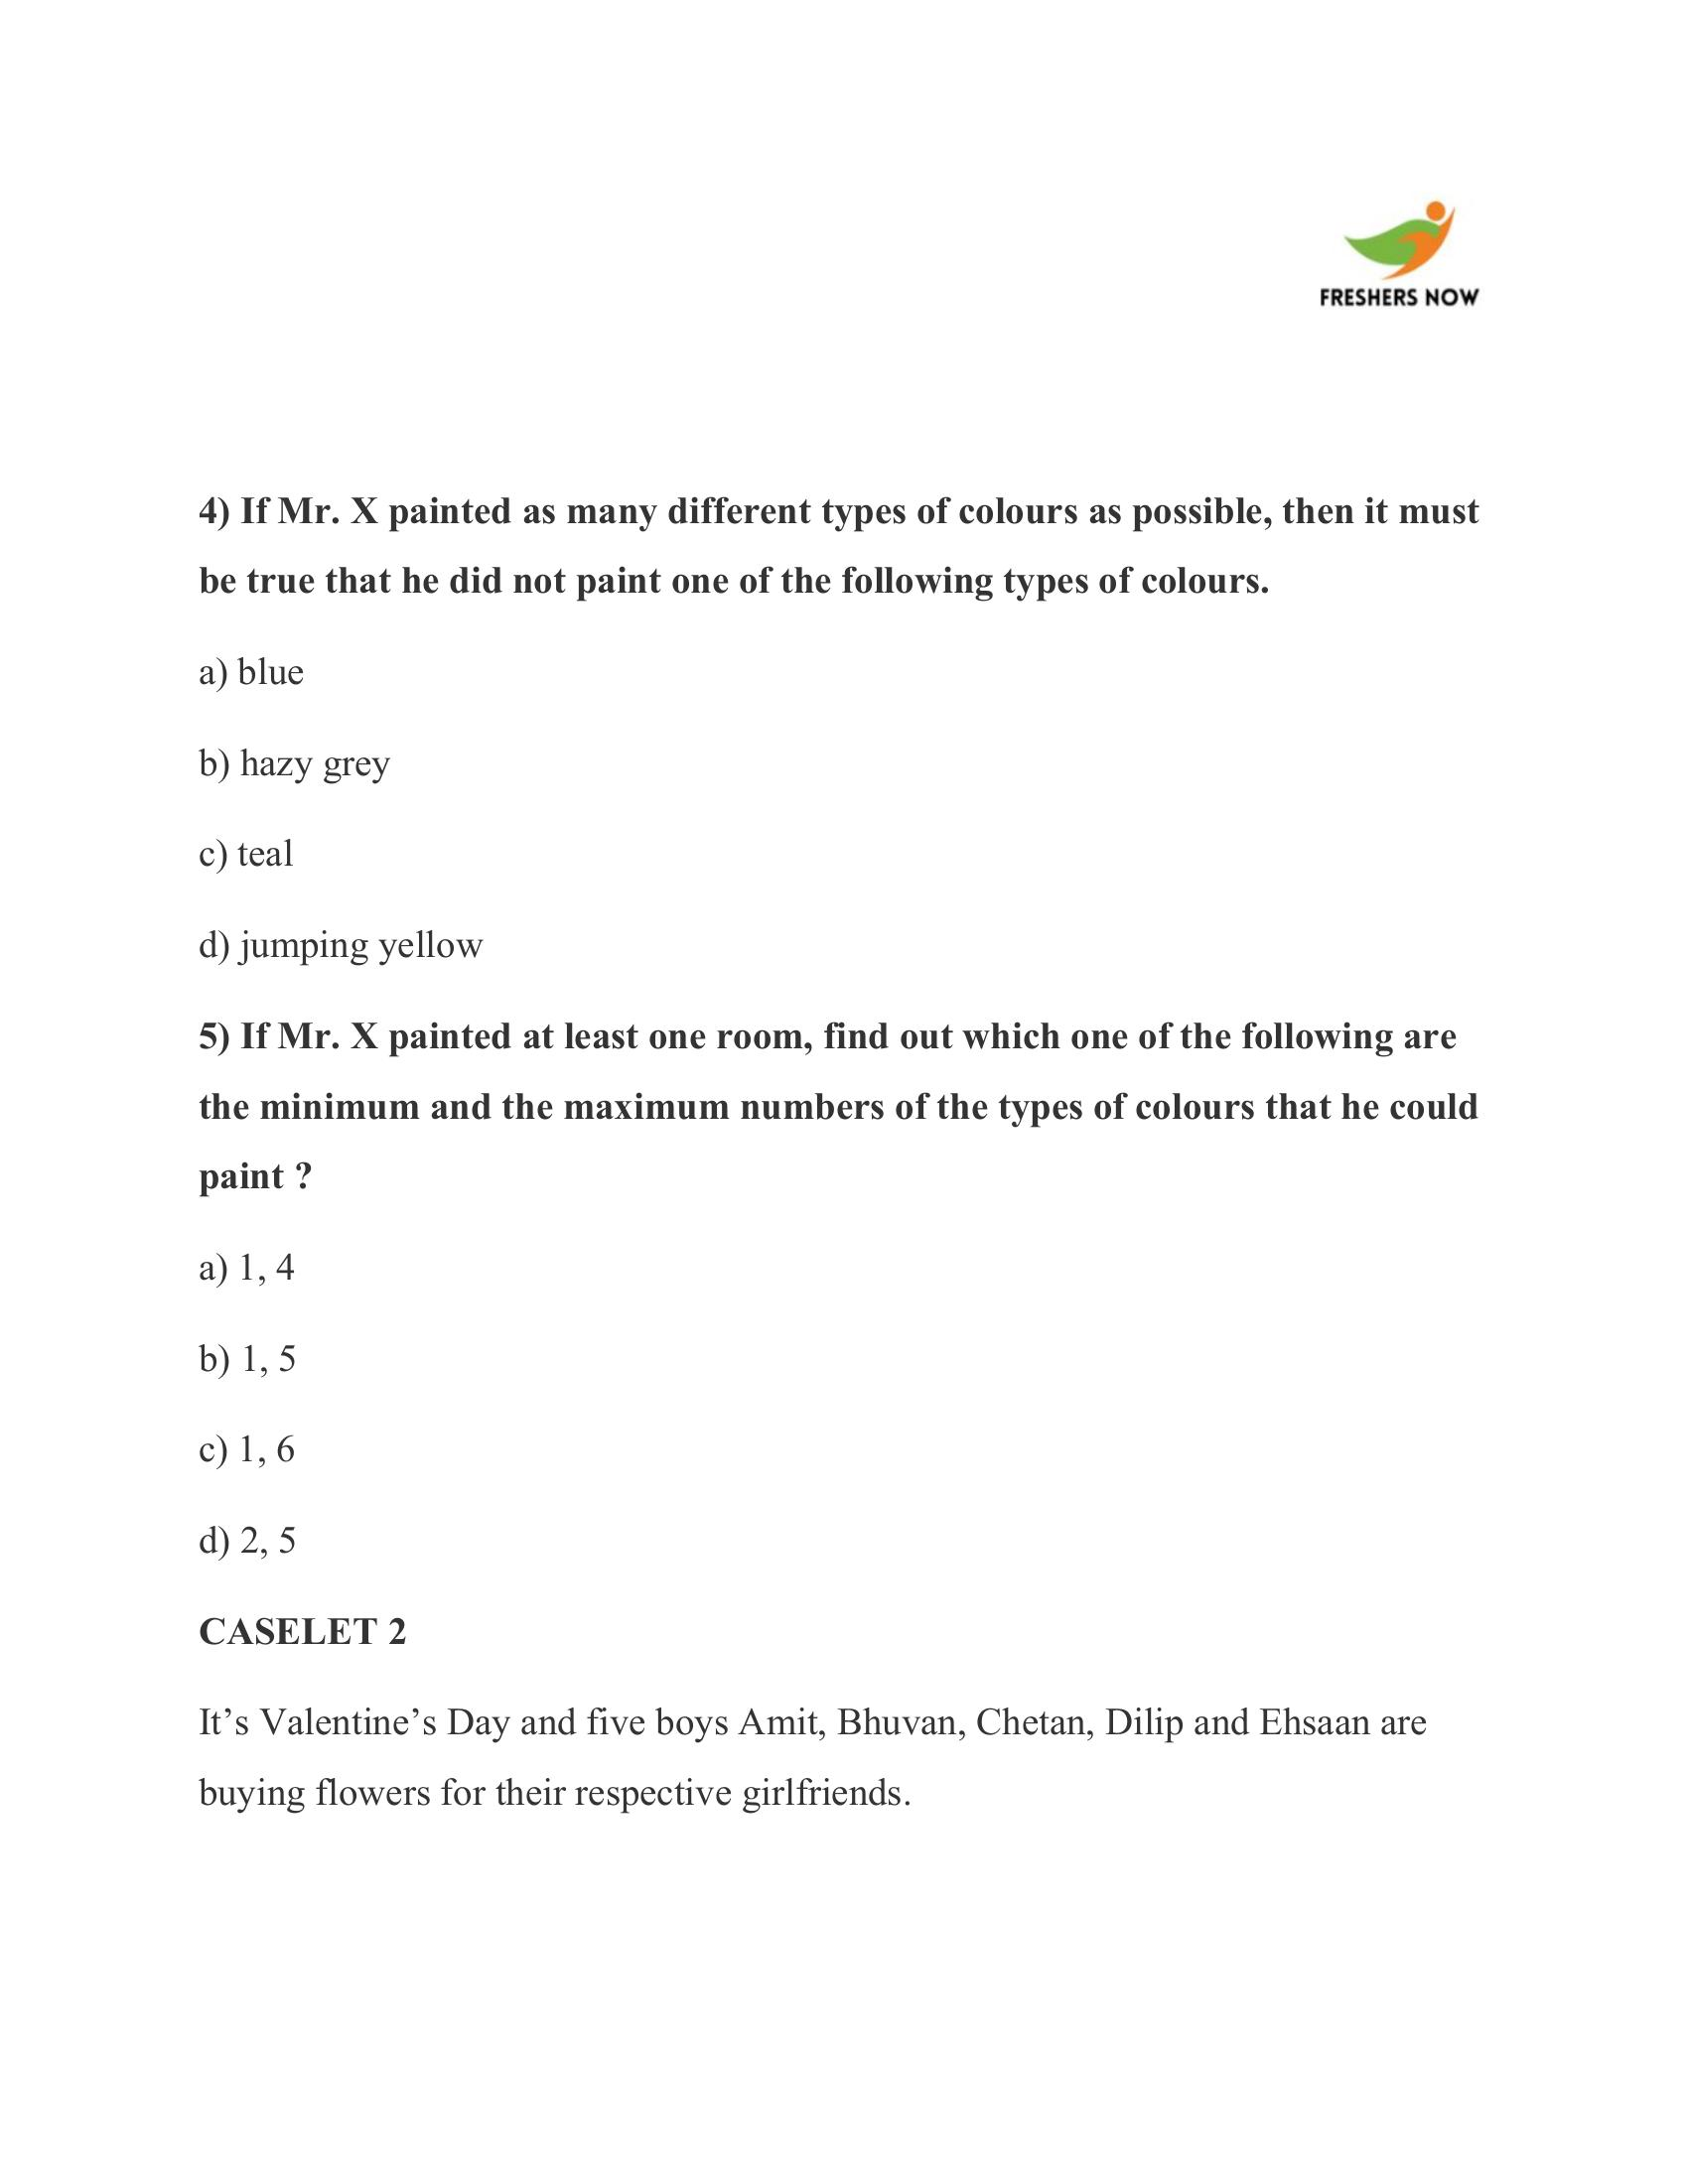

In [9]:
Image.open(io.BytesIO(page_images[2]))

In [30]:
#| export
model = LiltForTokenClassification.from_pretrained(OUTPUT_PATH/'LiLTmodel')
model_id="SCUT-DLVCLab/lilt-roberta-en-base"
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True) 
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

def unnormalize_box(bbox, width, height):
    return [width * (bbox[0] / 1000), height * (bbox[1] / 1000),
            width * (bbox[2] / 1000), height * (bbox[3] / 1000)]

label2color = {
    
    'B-CHART': 'magenta', 'B-Q': 'red', 'B-SUB-Q': 'darkgreen', 
    'B-SUB-SUB-Q': 'green', 'B-SUBJECT NAME': 'lightblue', 'B-TABLE': 'orange',
    
    'E-CHART': 'pink', 'E-Q': 'maroon', 'E-SUB-Q': 'darkgreen', 
    'E-SUB-SUB-Q': 'darkred', 'E-SUBJECT NAME': 'cyan', 'E-TABLE': 'yellow',
    
    'I-CHART': 'violet', 'I-Q': 'blue', 'I-SUB-Q': 'green', 
    'I-SUB-SUB-Q': 'darkblue', 'I-TABLE': 'gold',

    'O': 'black',
    'S-CHART': 'purple'
 }

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image

def run_inference(image):
    #image = Image.open(io.BytesIO(image))
    image = image.convert("RGB")
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    ## get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    ocr_text = tokenizer.decode(encoding.input_ids[0])
    predicted_labels = [model.config.id2label[label] for label in predictions]
    ocr_with_labels = list(zip(ocr_text.split(), predicted_labels))
    #result_image = draw_boxes(image, encoding["bbox"][-1], labels)
    ## convert resulting image back to byte array
    #result_byte_arr = io.BytesIO()
    #result_image.save(result_byte_arr, format='jpeg')
    #return #result_byte_arr.getvalue()
    # Return dataframe of predictions and labels
    print(len(ocr_with_labels))
    return pd.DataFrame({
        "labels": labels, 
        "predictions": predictions, 
        "ocr_text": ocr_text,
        #"ocr_with_labels": ocr_with_labels
        })#, ocr_with_labels, ocr_text.split())

run_inference(Image.open(io.BytesIO(page_images[2])))

/home/prabhanshu/mambaforge/envs/fastai/lib/python3.10/site-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


105


,labels,predictions,ocr_text
0,E-SUB-SUB-Q,3,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
1,O,10,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
2,O,10,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
3,O,10,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
4,O,10,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
...,...,...,...
147,I-Q,0,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
148,I-Q,0,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
149,I-Q,0,<s> wg FRESHERS NOW 4) If Mr. X painted as man...
150,E-SUB-SUB-Q,3,<s> wg FRESHERS NOW 4) If Mr. X painted as man...


In [13]:
for n,i in enumerate(page_images):
    pred = run_inference(i)
    print(pd.DataFrame({
        'page_num': n,
        "pred":[pred],
        'len': len(pred)
                        }))

AttributeError: 'bytes' object has no attribute 'convert'

In [ ]:
example_img = Image.open(io.BytesIO(page_images[0]))

In [ ]:
stop

### Gradio app

In [14]:
#| export
import gradio as gr

def ocr(image):
    # Preprocess byte image so that it can be used in the model
    
    return run_inference(image)

with gr.Blocks() as demo:
    gr.Markdown("Start typing below and then click **Run** to see the output.")
    with gr.Row():
        inp = gr.Image(type='pil')
        btn = gr.Button("Run")
    out = gr.Textbox()
    # providing an example pil image which can be then OCR'd
    # gr.Examples(
    #     [example_img],
    #     [inp],
    #     [out]
        
    # )
    btn.click(fn=ocr, inputs=inp, outputs=out)

demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


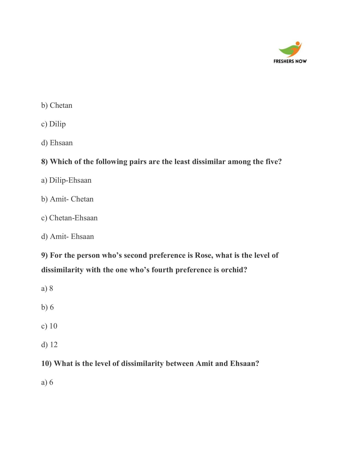

In [48]:
data_dir = PROJECT_HOME/'data/doc-scanner/5fe15b06-ee59-4461-9f88-505f3e4b2696'
image = Image.open(data_dir/'page_5_image_0.jpg')
image = image.convert("RGB")
image.resize((350,450))

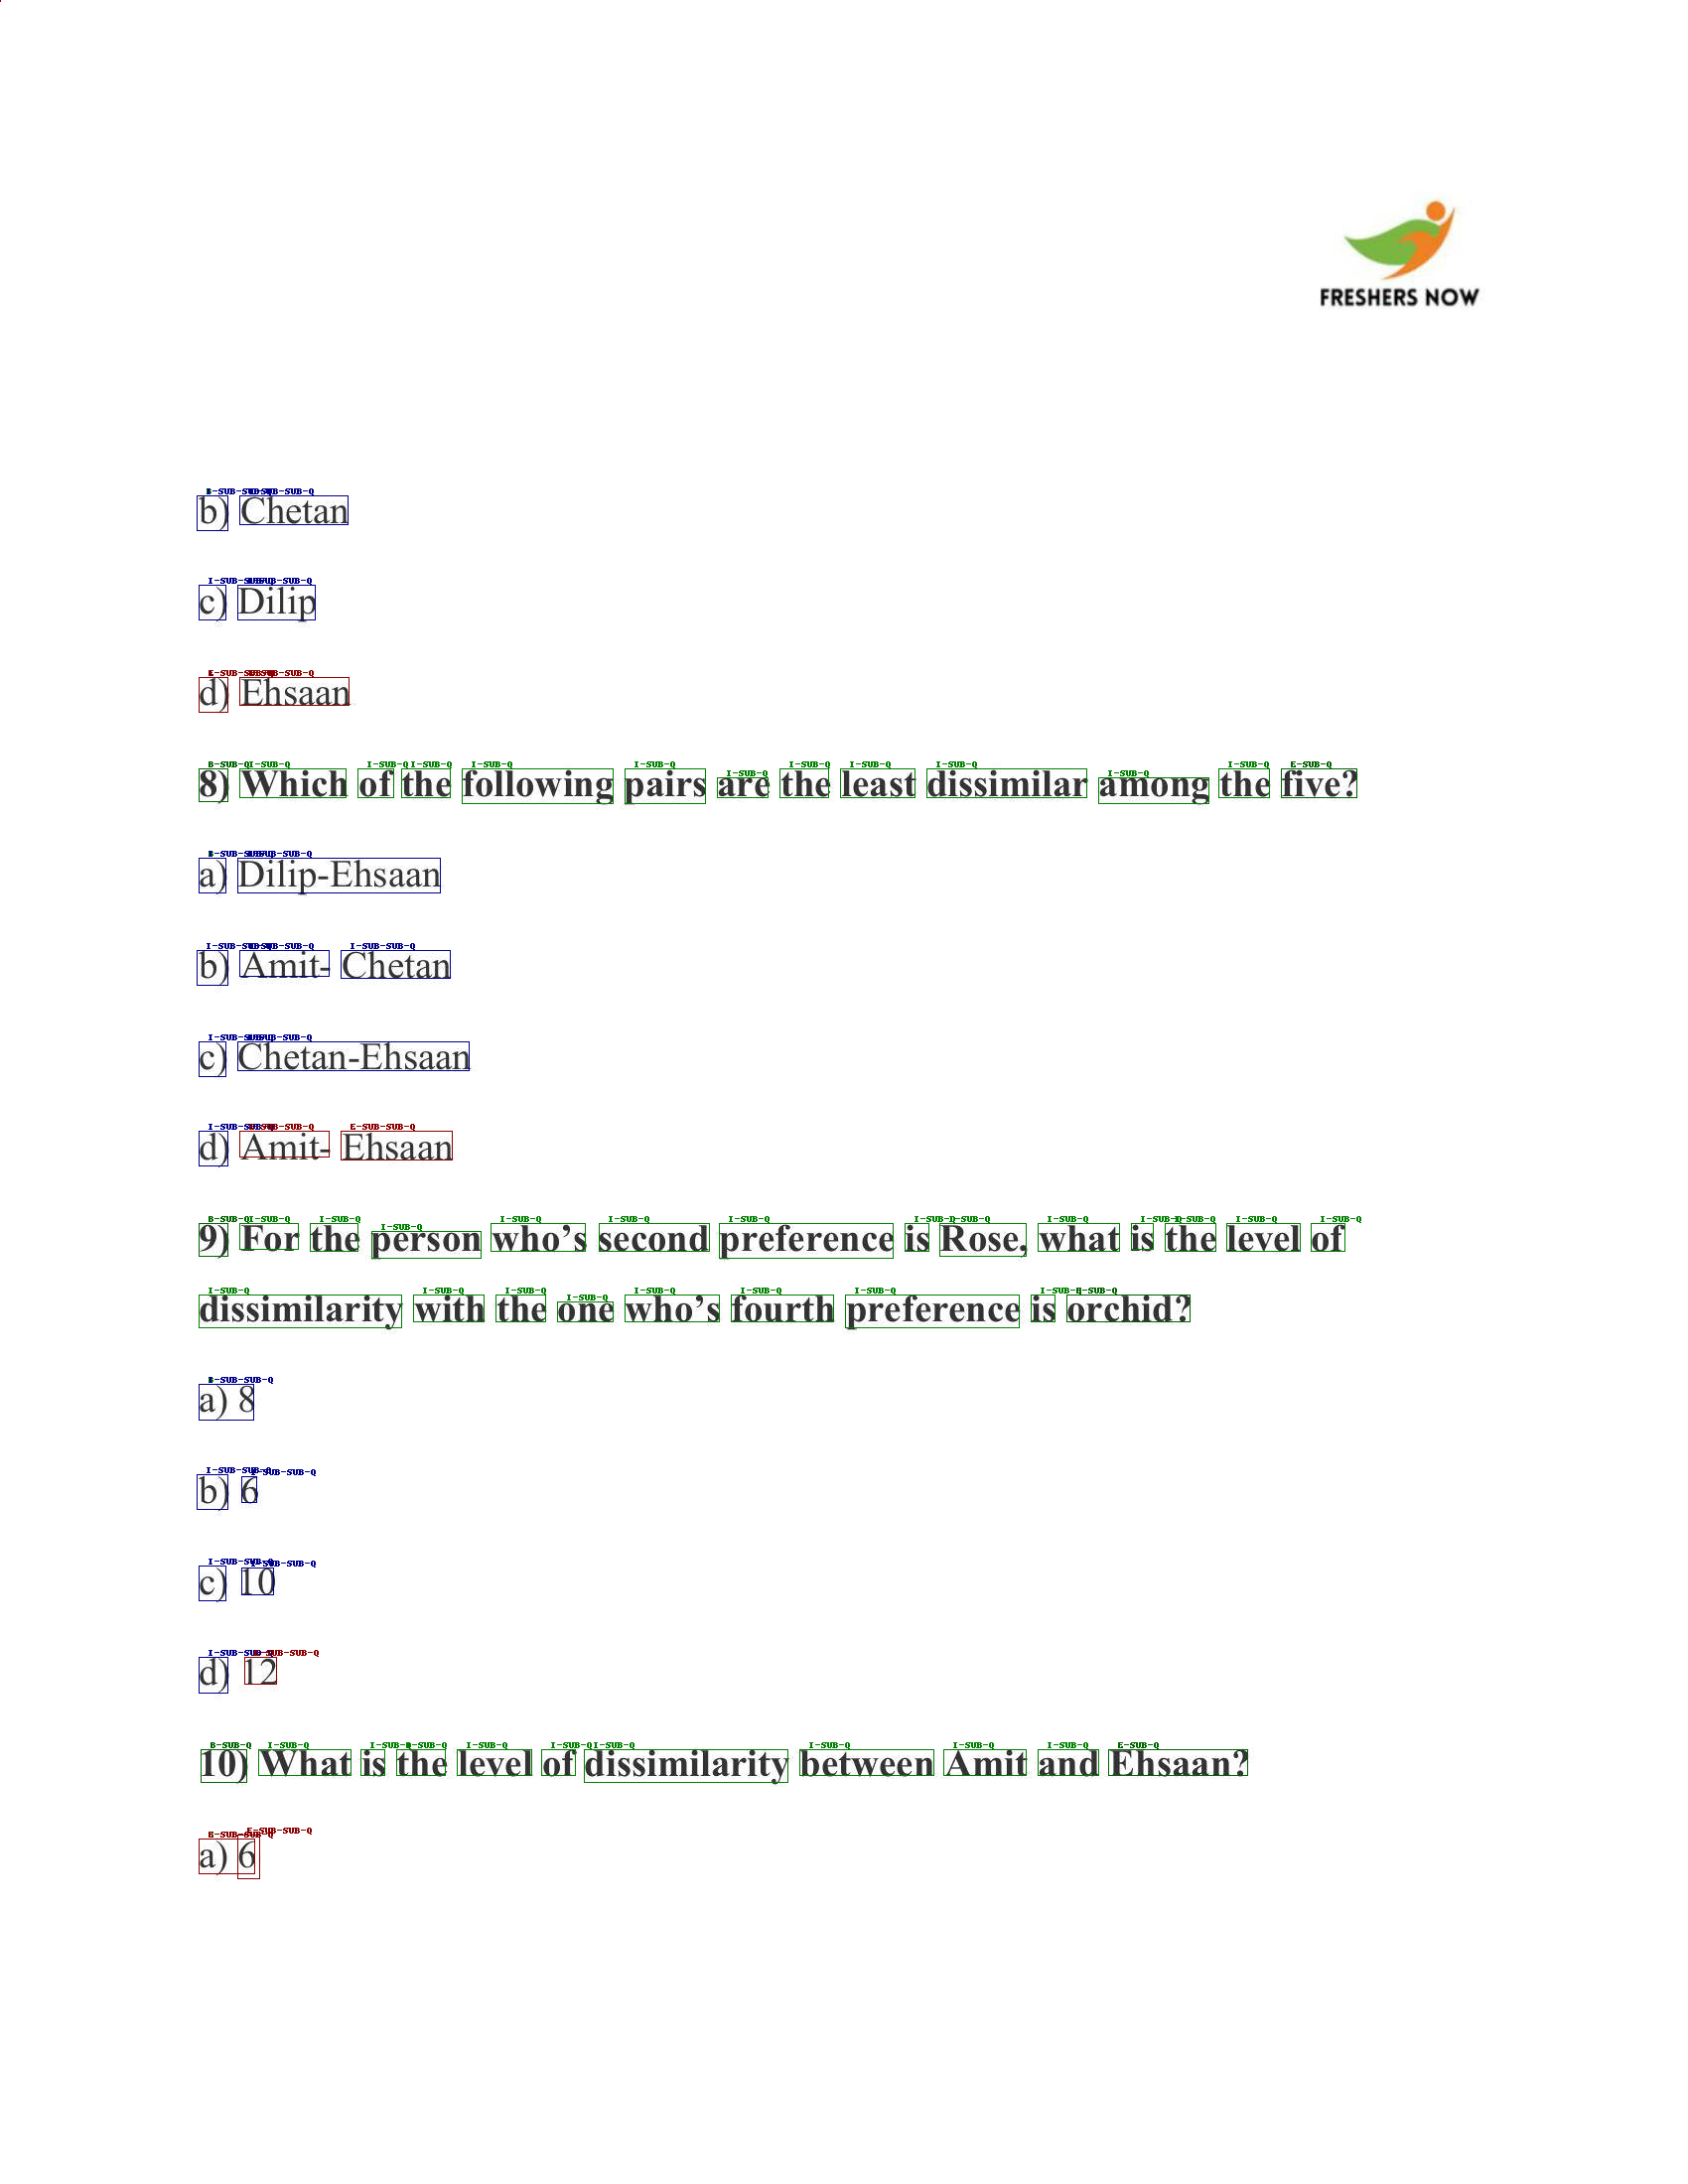

In [49]:
run_inference2(image)

In [38]:
encoding = processor(image, return_tensors="pt")
del encoding["pixel_values"]
# run inference
outputs = model(**encoding)
predictions = outputs.logits.argmax(-1).squeeze().tolist()
# get labels
labels = [model.config.id2label[prediction] for prediction in predictions]
#draw_boxes(image, encoding["bbox"][0], labels)
ocr_text = tokenizer.decode(encoding.input_ids[0])
# extract labels
predicted_labels = []
for pred in predictions:
    predicted_labels.append(model.config.id2label[pred])
# zip OCR text with corresponding labels
ocr_with_labels = list(zip(ocr_text.split(), predicted_labels))

In [44]:
all_(pd.DataFrame(ocr_with_labels))

,0,1
0,<s>,B-Q
1,FRESHERS,O
2,NOW,O
3,Each,O
4,of,O
5,these,B-Q
6,boys,I-Q
7,has,I-Q
8,a,I-Q
9,preference,I-Q


In [45]:
def display_all_rows(func):
    def wrapper(*args, **kwargs):
        with pd.option_context('display.max_rows', None):
            return func(*args, **kwargs)
    return wrapper

# modify the display function using the decorator
all_ = display_all_rows(display)

def run_inference2(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels

# Older code

In [ ]:
#| export
import torch
import numpy as np
import pandas as pd
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
# Project specific objects
from paper_solver.preprocess import *

****************************************
project home exist ? True
contents = ['.git', '.gitignore', 'README.md', 'nbs', '.github', 'LICENSE', 'MANIFEST.in', 'setup.py', 'paper_solver', 'nbdev-template-1.1.1', '.ipynb_checkpoints', '.gitconfig', '.gitattributes', 'paper_solver.egg-info', '_proc', 'data', 'preprocessed', 'settings.ini']
INPUT_PATH exist ? True
contents = ['data/doc-scanner/5fe15b06-ee59-4461-9f88-505f3e4b2696']
zip_dir_name 5fe15b06-ee59-4461-9f88-505f3e4b2696
Length of box, image and txt [1415, 1415, 1415]


Using saved model

In [ ]:
#| export
model = LiltForTokenClassification.from_pretrained(OUTPUT_PATH/'LiLTmodel')
model_id="SCUT-DLVCLab/lilt-roberta-en-base"
# vim binding to find the strings under selection in vim ?
# 

NameError: name 'LiltForTokenClassification' is not defined

Using LayoutLMv3 processor  
Cannot use from_pretrained since the processor is not saved in the base model

## Tokenizing

In [ ]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True) 
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

/home/prabhanshu/mambaforge/envs/fastai/lib/python3.10/site-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


helper function to unnormalize bboxes for drawing onto the image

## Inference

### Helper functions

In [ ]:
#| export
def unnormalize_box(bbox, width, height):
    return [width * (bbox[0] / 1000), height * (bbox[1] / 1000),
            width * (bbox[2] / 1000), height * (bbox[3] / 1000)]

label2color = {
    'I-Q': 'blue',
    'O': 'black',
    'E-TABLE': 'yellow',
    'B-SUB-SUB-Q': 'green',
    'B-SUB-Q': 'darkgreen',
    'S-CHART': 'purple',
    'B-TABLE': 'orange',
    'E-SUB-Q': 'darkgreen',
    'I-SUB-Q': 'green',
    'I-TABLE': 'gold',
    'B-Q': 'red',
    'B-CHART': 'magenta',
    'E-CHART': 'pink',
    'I-SUB-SUB-Q': 'darkblue',
    'E-Q': 'maroon',
    'E-SUBJECT NAME': 'cyan',
    'E-SUB-SUB-Q': 'darkred',
    'B-SUBJECT NAME': 'lightblue',
    'I-CHART': 'violet'
}

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image

In [ ]:
#| export
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels

### Taking one image as example

In [ ]:
#| export
data_dir = PROJECT_HOME/'data/doc-scanner/5fe15b06-ee59-4461-9f88-505f3e4b2696'

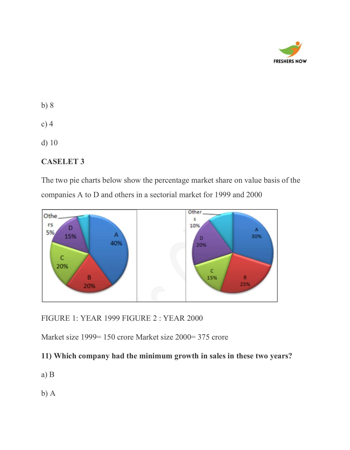

In [ ]:
#| export
from PIL import Image, ImageDraw, ImageFont

image = Image.open(data_dir/'page_6_image_0.jpg')
image = image.convert("RGB")
image.resize((350,450))

### Inference step

In [ ]:
#| export
encoding = processor(image, return_tensors="pt")
del encoding["pixel_values"]
# run inference
outputs = model(**encoding)
predictions = outputs.logits.argmax(-1).squeeze().tolist()
# get labels
labels = [model.config.id2label[prediction] for prediction in predictions]
#draw_boxes(image, encoding["bbox"][0], labels)

In [ ]:
#| export
# extract OCR text
ocr_text = tokenizer.decode(encoding.input_ids[0])
# extract labels
predicted_labels = []
for pred in predictions:
    predicted_labels.append(model.config.id2label[pred])
# zip OCR text with corresponding labels
ocr_with_labels = list(zip(ocr_text.split(), predicted_labels))
print('ocr_text', ocr_text)

ocr_text <s> FRESHERS NOW b) 8 c)4 d) 10 CASELET 3 The two pie charts below show the percentage market share on value basis of the companies A to D and others in a sectorial market for 1999 and 2000 Other $s 10%, FIGURE 1: YEAR 1999 FIGURE 2 : YEAR 2000 Market size 1999= 150 crore Market size 2000= 375 crore 11) Which company had the minimum growth in sales in these two years? a)B b)A</s>


In [ ]:
import pytesseract
text = pytesseract.image_to_string(image)
print(text)

FRESHERS NOW

b) 8

c)4

d) 10
CASELET 3

The two pie charts below show the percentage market share on value basis of the

companies A to D and others in a sectorial market for 1999 and 2000

Other
$s
10%,

FIGURE 1: YEAR 1999 FIGURE 2 : YEAR 2000

Market size 1999= 150 crore Market size 2000= 375 crore

11) Which company had the minimum growth in sales in these two years?
a)B

b)A



In [ ]:
# Perform OCR using pytesseract
#text = pytesseract.image_to_string(image)
# Print the extracted text
#print(text)

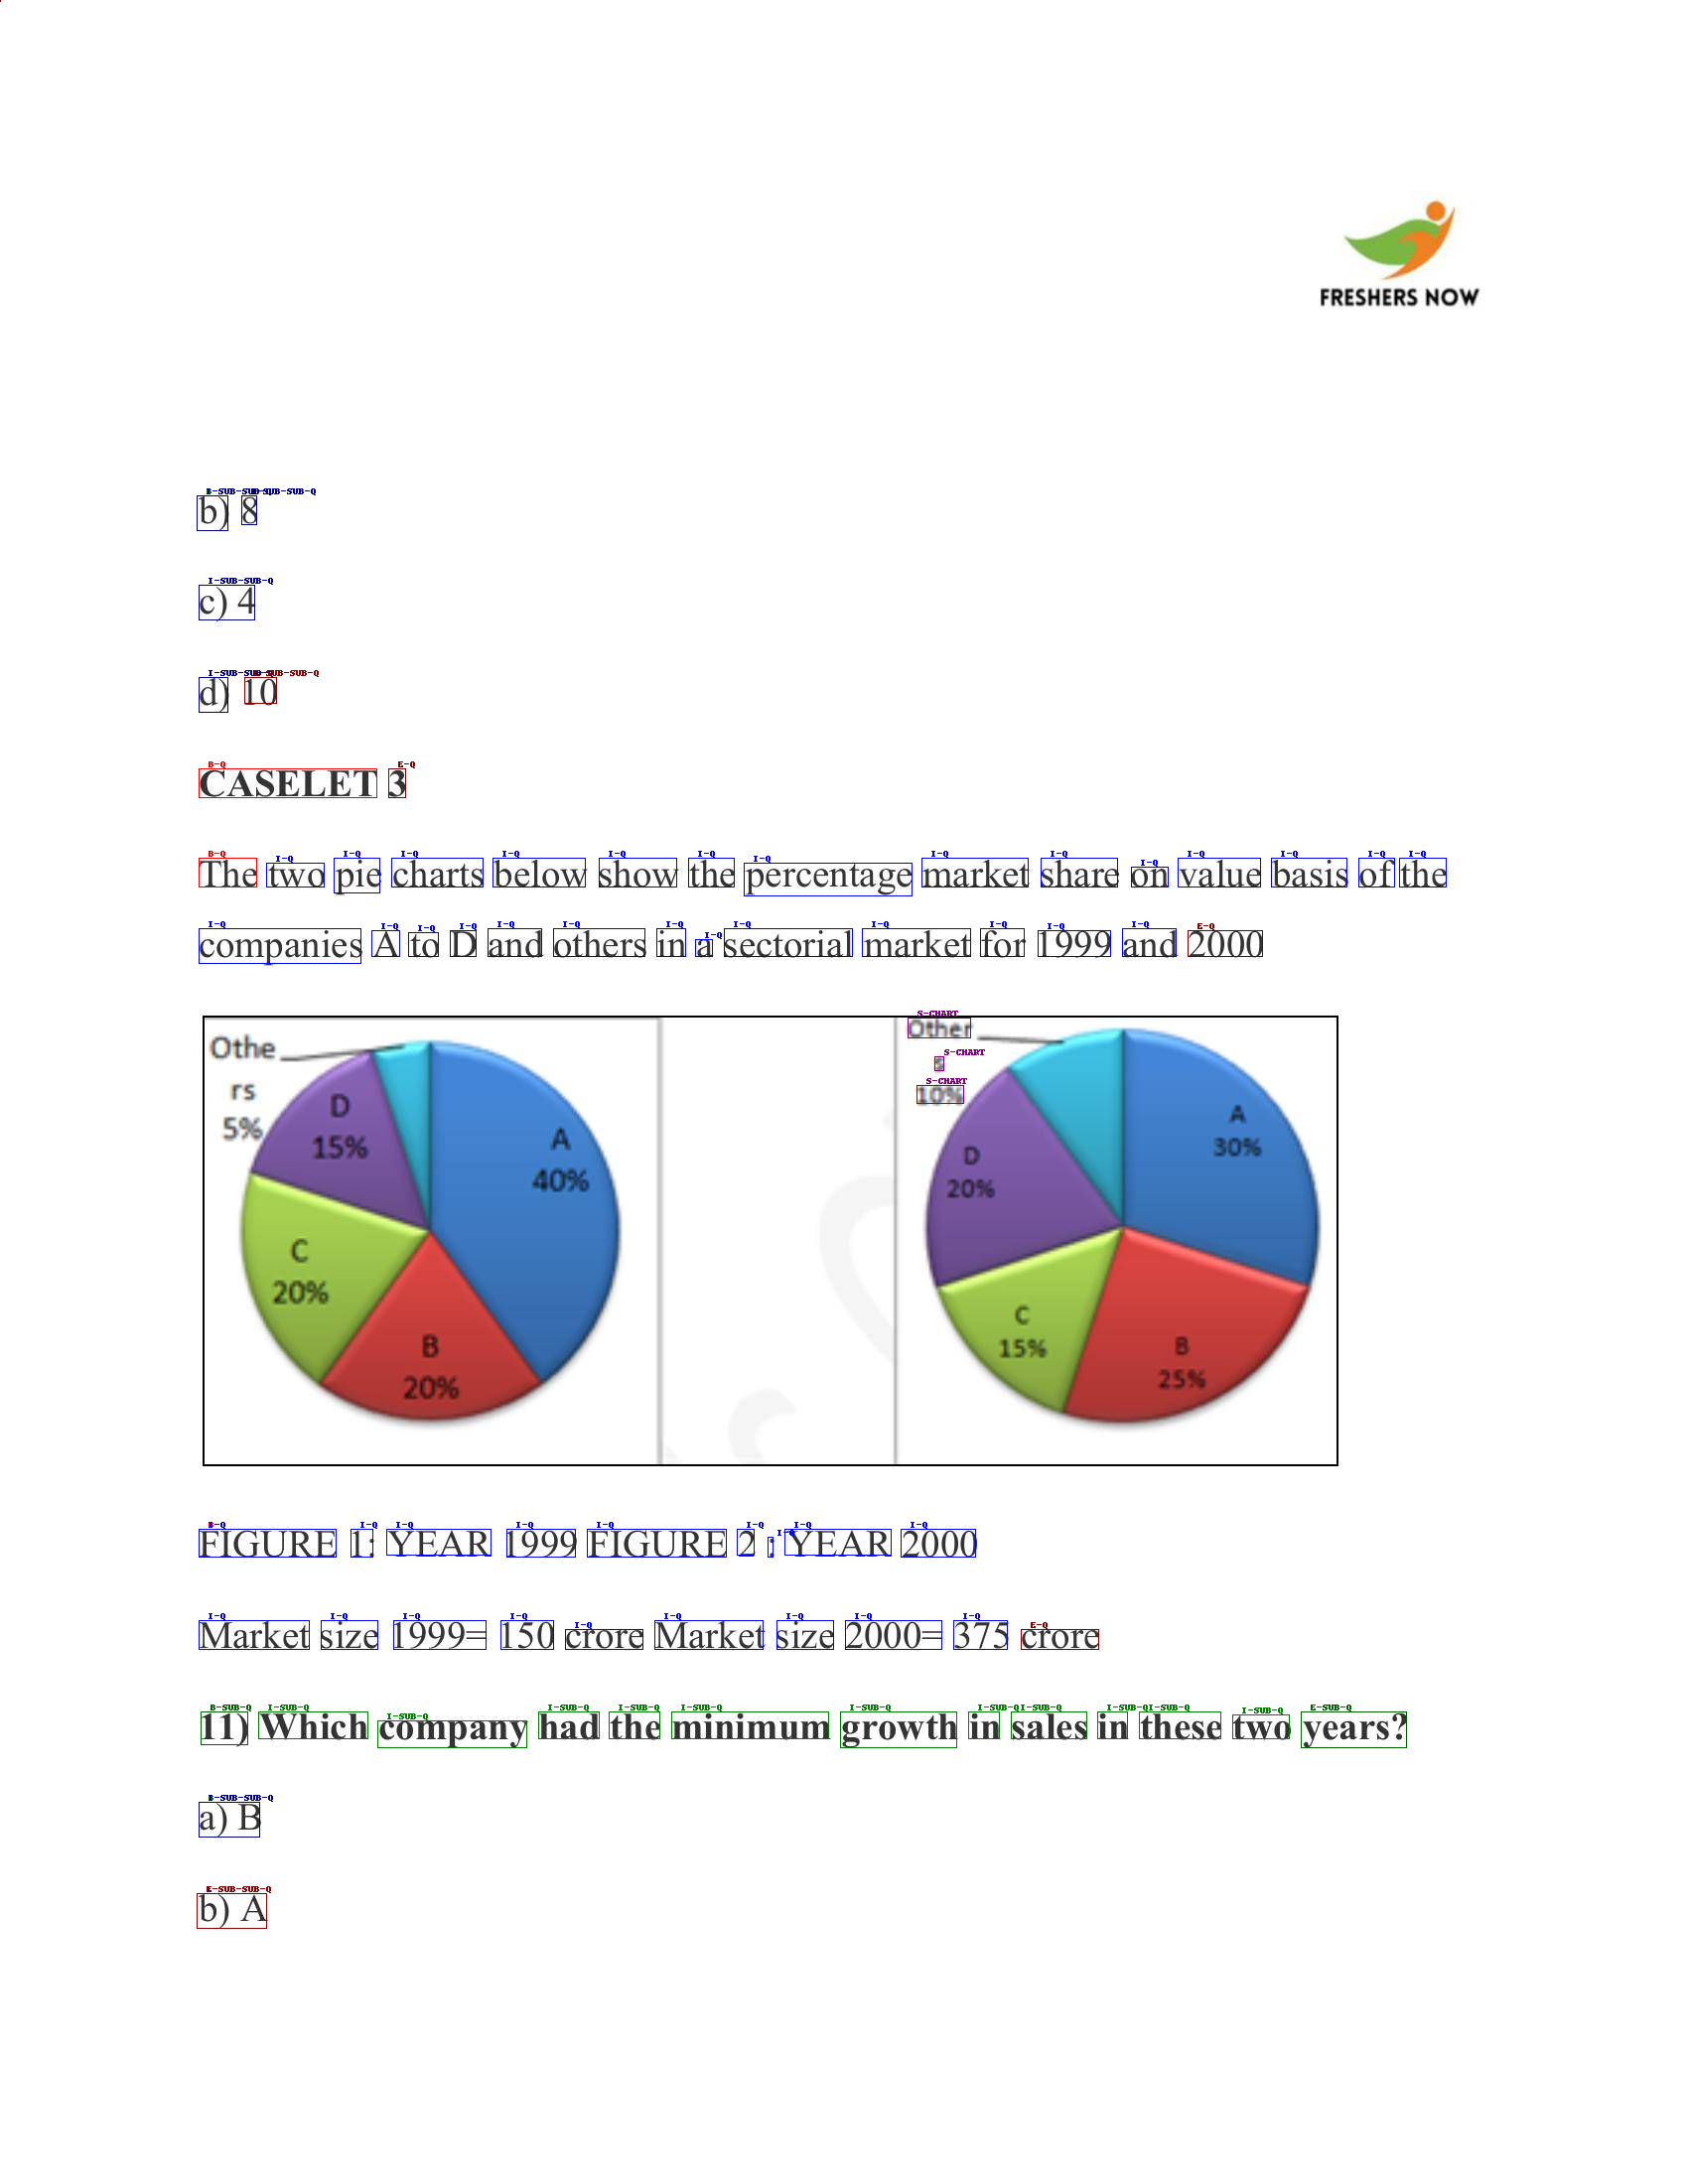

In [ ]:
run_inference(image)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()